In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, roc_curve, roc_auc_score, f1_score
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel

# load tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
# embedding layer:
bert=TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [2]:
def split_data(train_path,split_ratio,seed):
    '''
    X_train, X_test, y_train, y_test=split_data(train_path,split_ratio,seed)
    '''
    train_df=pd.read_csv(train_path)
    # randomize the data
    train_shuffle_df=train_df[['text','target']].sample(frac=1,random_state=seed)
    X=train_shuffle_df['text'].to_numpy()
    y=train_shuffle_df['target'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)
    return X_train, X_test, y_train, y_test

In [3]:
def evaluation_matrix(y_true,y_pred):
    '''
    eval_dictionary=evaluation_matrix(y_true,y_pred)
    '''
    f1score=f1_score(y_true,y_pred)
    recallscore=recall_score(y_true,y_pred)
    accuracy=sum(y_true==y_pred)/len(y_true)
    tn, fp, fn, tp =confusion_matrix(y_true,y_pred).ravel()
    pre_score=precision_score(y_true,y_pred)
    res={'f1_score':f1score,
         'recall_score':recallscore,
        'accuracy':accuracy,
        'False Positive':fp,
        'False Negative':fn,
        'precision_score':pre_score}
    return res

In [6]:
X_train, X_test, y_train, y_test=split_data('train.csv',0.1,42)

In [7]:
len(X_train),len(X_test),len(y_train),len(y_test)

(6851, 762, 6851, 762)

In [8]:
# Tokenize phrases
tokens=tokenizer(X_train.tolist(),max_length=512,truncation=True,padding='max_length',add_special_tokens=True,return_tensors='np')

In [9]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [10]:
Xids=tokens['input_ids']
Xmask=tokens['attention_mask']

In [11]:
Xids.shape[0]

6851

In [13]:
labels=np.expand_dims(y_train,axis=1)
labels.shape

(6851, 1)

In [14]:
dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))

In [15]:
def map_func(input_ids,masks,labels):
    return {'input_ids':input_ids,
            'attention_mask':masks},labels

In [16]:
dataset=dataset.map(map_func)

In [17]:
dataset

<MapDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (1,)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>

In [18]:
batch_size=16
dataset=dataset.shuffle(10000).batch(batch_size,drop_remainder=True)

In [19]:
dataset.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 1), dtype=tf.int64, name=None))

In [20]:
# 80% training data and 20% validation data
split=0.8
size=int((Xids.shape[0]/batch_size)*split)
size

342

In [21]:
# Create train and validation dataset
train_ds=dataset.take(size)
val_ds=dataset.skip(size)

In [22]:
#let's build the model
input_ids=tf.keras.layers.Input(shape=(512,),name='input_ids',dtype='int32')
mask=tf.keras.layers.Input(shape=(512,),name='attention_mask',dtype='int32')
embeddings=bert.bert(input_ids,attention_mask=mask)[1]
#classification head
x=tf.keras.layers.Dense(32,activation='relu')(embeddings)
y=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(x)
model=tf.keras.Model(inputs=[input_ids,mask],outputs=y)

In [23]:
model.layers

In [24]:
model.layers[2].trainable=False

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       bert[0][1]                   

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [27]:
history=model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=[callback])

Epoch 1/20
342/342 [==============================] - 197s 563ms/step - loss: 0.6463 - accuracy: 0.6268 - val_loss: 0.5880 - val_accuracy: 0.6940
Epoch 2/20
342/342 [==============================] - 191s 557ms/step - loss: 0.6029 - accuracy: 0.6789 - val_loss: 0.5718 - val_accuracy: 0.7231
Epoch 3/20
342/342 [==============================] - 190s 557ms/step - loss: 0.5894 - accuracy: 0.6966 - val_loss: 0.5698 - val_accuracy: 0.7100
Epoch 4/20
342/342 [==============================] - 191s 557ms/step - loss: 0.5802 - accuracy: 0.7045 - val_loss: 0.5317 - val_accuracy: 0.7594
Epoch 5/20
342/342 [==============================] - 179s 523ms/step - loss: 0.5601 - accuracy: 0.7197 - val_loss: 0.5243 - val_accuracy: 0.7493
Epoch 6/20
342/342 [==============================] - 193s 564ms/step - loss: 0.5579 - accuracy: 0.7244 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 7/20
342/342 [==============================] - 192s 562ms/step - loss: 0.5539 - accuracy: 0.7295 - val_loss: 0.5161 -

<Axes: >

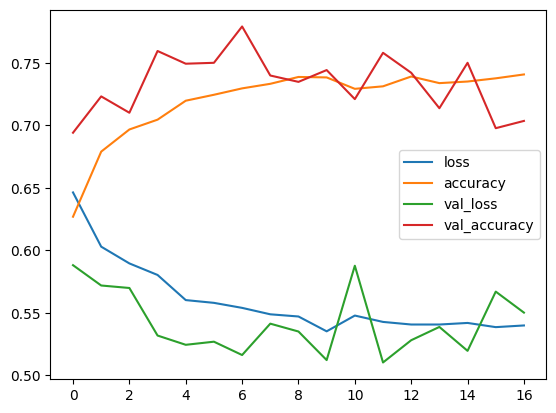

In [31]:
pd.DataFrame(history.history).plot()

In [29]:
def prep_data(text):
    tokens=tokenizer(text,max_length=512,truncation=True,padding='max_length',add_special_tokens=True,return_tensors='tf')
    return {'input_ids':tokens['input_ids'],'attention_mask':tokens['attention_mask']}              

In [30]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


In [32]:
model.predict(prep_data('Hello World')).item()

0.1557450145483017

In [33]:
pred=[]
for text in X_test:
    pred.append(model.predict(prep_data(text)).item())

In [34]:
y_pred=np.round(pred)

In [35]:
evaluation_matrix(y_test,y_pred)

{'f1_score': 0.7231920199501247,
 'recall_score': 0.8333333333333334,
 'accuracy': 0.7086614173228346,
 'False Positive': 164,
 'False Negative': 58,
 'precision_score': 0.6387665198237885}